# Introduksjon til bredbåndsanalyse av lydsignal

Dette dokumentet forklarer hvordan funksjonen `BB_data` benyttes til å hente ut effektomslaget (envelopen) til et lydsignal. 
Metoden baserer seg på **Hilbert-transformasjon**, kvadrering og filtrering – og gir et signal som representerer den momentane effekten av det opprinnelige signalet.

I dokumentet går vi gjennom både kode, teori og praktiske implikasjoner av signalbehandlingen, med mål om å gi en pedagogisk og intuitiv forståelse. Dette er særlig nyttig for bruk i sanntidsanalyse (live processing) av akustiske signaler.


In [36]:
def BB_data(sx, fs, sx_buff, hilbert_win, window_size):
    """
    PARAMETERS:
        sx: array of float
            Audio signal in time domain
        fs: int
            samplerate of sx
        sx_buff: array of float
            Buffered processed signal from last segment (Live implementation)
        hilbert_win: int
            No. of samples used for downsamlpling
        window_size: float
            No. of seconds used for filtering

    RETURN:
        BB_sig: array of float
            Logarithmic representation of power-envelope
        t: array of float
            time array corresponding to BB_sig
        sx_buff_out: array of float
            Buffered processed signal from last segment (Live implementation)
    """
    # Apply Hilbert transform to the signal, take the absolute value, square the result (power envelope), and then apply a median filter
    # to smooth the squared analytic signal. The window size for the median filter is defined by `medfilt_window`.
    envelope = moving_average_padded(np.square(np.abs(hilbert(sx))),hilbert_win)

    # Downsample the filtered signal
    DS_Sx = resample_poly(envelope, 1, hilbert_win)  # Resample by the median filter window size
    DS_Fs = fs / hilbert_win  # New sampling rate after downsampling

    # Define kernel size for the median filter based on window size
    kernel_size = int(window_size * DS_Fs) | 1  # Ensure odd size
    signal_med = moving_average_zero_padded(DS_Sx, kernel_size)  # Apply median filter for further noise removal

    #Removing invalid values
    signal_med = signal_med[kernel_size//2:-kernel_size//2]

    #Adding last of previous to start
    signal_med[:len(sx_buff)] += sx_buff

    #Preparing buffer for next segment
    sx_buff_out = signal_med[-kernel_size:]

    #Cutting end of current
    signal_med = signal_med[:-kernel_size]


    BB_sig = 10*np.log10(signal_med)
    t = np.linspace(0,len(BB_sig)/DS_Fs,len(BB_sig))
    return BB_sig, t, sx_buff_out



def moving_average_zero_padded(signal, window_size=5):
    pad_size = window_size // 2
    padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Repeat edge values
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(padded_signal, kernel, mode="full")  # Only keep valid parts
    return smoothed

## Fra råsignal til effektomslag

Funksjonen `BB_data` omformer et rått lydsignal til en representasjon av dets effektomslag (power envelope). 

Stegene er:
1. **Hilbert-transformasjon**: Gir et analytisk signal hvor amplitudeomslaget kan hentes ut.
2. **Absoluttverdi** og **kvadrering**: Gir en størrelse som representerer momentan effekt.
3. **Filtrering og nedsampling**: Reduserer støy, glattgjør dataen, og gjør datastrømmen lettere å håndtere i sanntid.

For filtreringen brukes `moving_average_zero_padded()`, som er et glidende gjennomsnitt (MA-filter) med null-padding. Dette gir randeffekter – dvs. at starten og slutten av signalet trekkes nedover – illustrert nedenfor.


Text(0.5, 0, 'Time [s]')

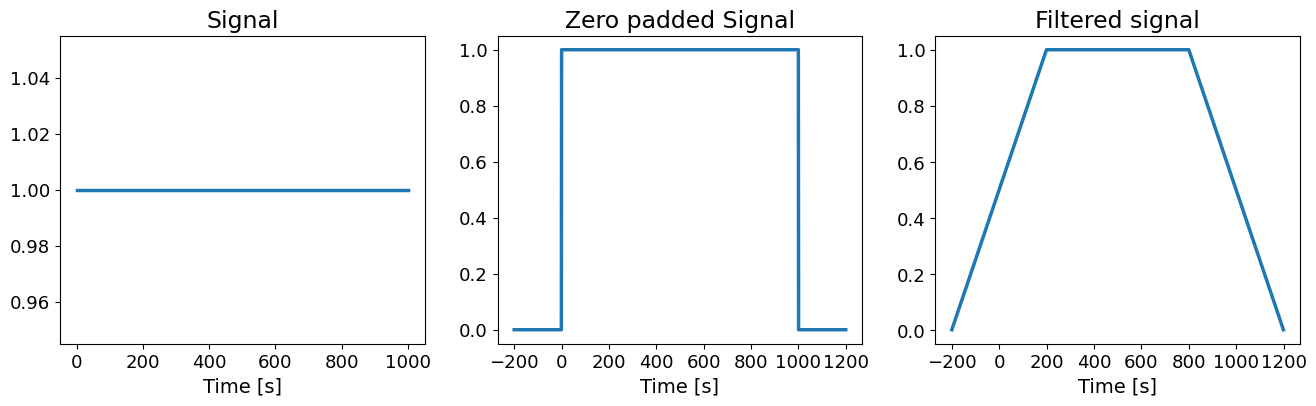

In [37]:
import numpy as np
import matplotlib.pyplot as plt
fontsize=14
linewidth=2.5
signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet
smoothed = smoothed[int(window_size/2):int(-window_size/2)]
fig = plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
t = np.linspace(0,len(signal),len(signal))
plt.plot(t,signal,linewidth=linewidth)
plt.xlabel("Time [s]",fontsize=fontsize)
plt.title("Signal",fontsize=fontsize+3)
plt.yticks(fontsize=fontsize-1)
plt.xticks(fontsize=fontsize-1)

plt.subplot(1,3,2)
padded_t = np.linspace(0,len(padded_signal),len(padded_signal))
plt.plot(padded_t-window_size/2,padded_signal,linewidth=linewidth)
plt.xlabel("Time [s]",fontsize=fontsize)
plt.title("Zero padded Signal",fontsize=fontsize+3)
plt.yticks(fontsize=fontsize-1)
plt.xticks(fontsize=fontsize-1)

plt.subplot(1,3,3)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size/2,smoothed,linewidth=linewidth)
plt.xticks([-200,0,200,400,600,800,1000,1200],fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)
plt.title("Filtered signal",fontsize=fontsize+3)
plt.xlabel("Time [s]",fontsize=fontsize)



## Signalets lengde etter filtrering

Filtrering og padding påvirker signalets lengde. Her er et overslag:

- La original lengde være `N`
- Med `window_size` null-padding får vi:
  ```
  len(padded_signal) = N + window_size
  len(smoothed) = len(padded_signal) + len(kernel) \
                = (N + window_size) + window_size - 1 \
                = N + 2 * window_size - 1
  ```

**Eksempel:**
```python
N = 1000
window_size = 400
len(smoothed) = 1799
```

Denne veksten skyldes konvolusjonsoperasjonen med et symmetrisk filter og padding.


## Randeffekter og trimming

De flate kantene som oppstår etter filtreringen inneholder **ikke** ny informasjon og bør derfor fjernes. 
Derimot inneholder det padde området (i starten og slutten) **gyldig informasjon** som skyldes filtrering av det ekte signalet – og må bevares.

Dette fører til at det resulterende signalet ser ut som figuren under.


(array([-400., -200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.,
        1400.]),
 [Text(-400.0, 0, '−400'),
  Text(-200.0, 0, '−200'),
  Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200'),
  Text(1400.0, 0, '1400')])

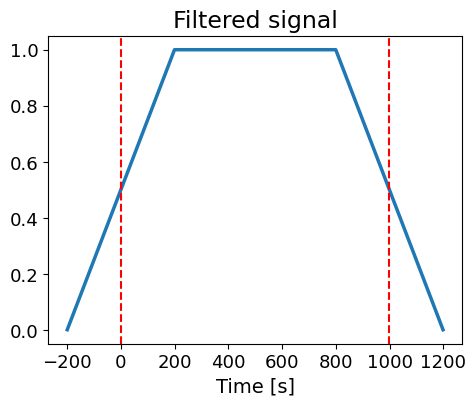

In [44]:
import numpy as np
import matplotlib.pyplot as plt
fontsize = 14
linewidth=2.5
signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16/3,4))

smoothed = smoothed[window_size//2:-window_size//2]

smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size/2,smoothed,linewidth=linewidth)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = len(smoothed) - window_size, color="red", linestyle="--")
plt.title("Filtered signal",fontsize=fontsize+3)
plt.xlabel("Time [s]",fontsize=fontsize)
plt.yticks(fontsize=fontsize-1)
plt.xticks(fontsize=fontsize-1)

## Tidsforskyvning og datastruktur

Det prosesserte signalet er nå lengre enn det opprinnelige, og det har blitt forskjøvet i tid. 
Start og slutt på det opprinnelige signalet er markert mellom røde linjer i figuren over.

Vi må kompensere for dette ved å forskyve signalet tilbake, slik at det harmonerer med originalens tidsreferanse.


(array([-400., -200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.,
        1400.]),
 [Text(-400.0, 0, '−400'),
  Text(-200.0, 0, '−200'),
  Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200'),
  Text(1400.0, 0, '1400')])

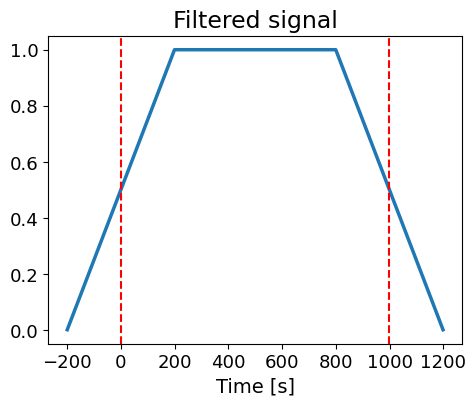

In [39]:
import numpy as np
import matplotlib.pyplot as plt
fontsize = 14
linewidth=2.5
signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16/3,4))

smoothed = smoothed[window_size//2:-window_size//2]

smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size//2,smoothed,linewidth=linewidth)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = len(smoothed) - window_size, color="red", linestyle="--")
plt.title("Filtered signal",fontsize=fontsize+3)
plt.xlabel("Time [s]",fontsize=fontsize)
plt.yticks(fontsize=fontsize-1)
plt.xticks(fontsize=fontsize-1)

## Live bruk: Kontinuerlig databehandling

`BB_data` er laget med tanke på sanntidsprosessering. Det betyr at et kontinuerlig lydsignal behandles segment for segment.

Et ferdig segment gir:
- Effektomslag (klar til plotting)
- En tidsakse
- En "buffer" som videreføres til neste segment

Denne overlappingen mellom segmentene er nødvendig for å opprettholde korrekt kontinuitet mellom dem.


([<matplotlib.axis.XTick at 0x314a94410>,
 [Text(-200.0, 0, '−200'),
  Text(500.0, 0, '500'),
  Text(1000.0, 0, '1000'),
  Text(1500.0, 0, '1500'),
  Text(2200.0, 0, '2200')])

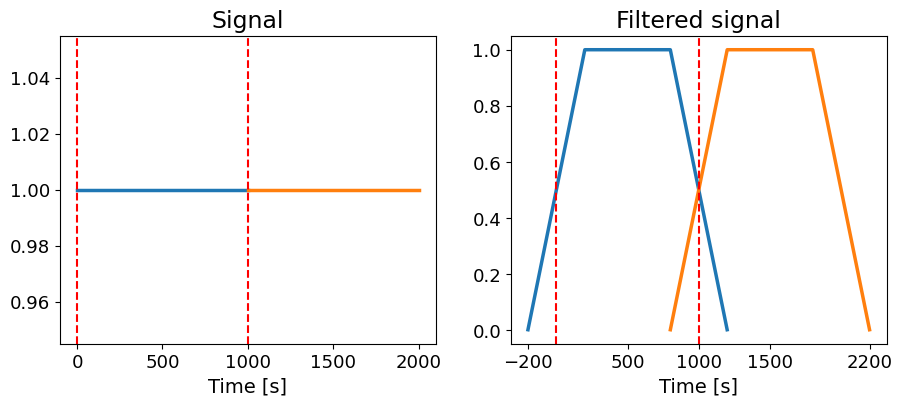

In [53]:
import numpy as np
import matplotlib.pyplot as plt
fontsize = 14
linewidth=2.5
signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16*2/3,4))



smoothed = smoothed[window_size//2:-window_size//2]
plt.subplot(1,2,1)
t = np.linspace(0,len(signal),len(signal))
plt.plot(t,signal,linewidth=linewidth)
plt.plot(t+1000,signal,linewidth=linewidth)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = 1000, color="red", linestyle="--")
plt.xlabel("Time [s]",fontsize=fontsize)
plt.title("Signal",fontsize=fontsize+3)
plt.yticks(fontsize=fontsize-1)
plt.xticks([0,500,1000,1500,2000],fontsize=fontsize-1)
plt.subplot(1,2,2)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size//2,smoothed,linewidth=linewidth)
plt.plot(smoothed_t + 1000 - window_size//2, smoothed,linewidth=linewidth)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = len(smoothed) - window_size, color="red", linestyle="--")
plt.title("Filtered signal",fontsize=fontsize+3)
plt.xlabel("Time [s]",fontsize=fontsize)
plt.yticks(fontsize=fontsize-1)
plt.xticks([-window_size/2,500,1000,1500,2000+window_size/2],fontsize=fontsize-1)

## Randeffekter og Overlap-Add (OLA)

Filtrering introduserer symmetriske randeffekter på begge sider. For å unngå forvrengning ved segmentoverganger, benytter vi **Overlap-Add (OLA)**.

Dette innebærer:
- Høyre rand av et segment lagres i en buffer.
- Neste segment prosesseres sammen med denne bufferen som input.
- Signalene summeres i overgangssonen, og randeffektene kanselleres.

Resultatet er sømløs overgang mellom segmenter uten forsinkelse.


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

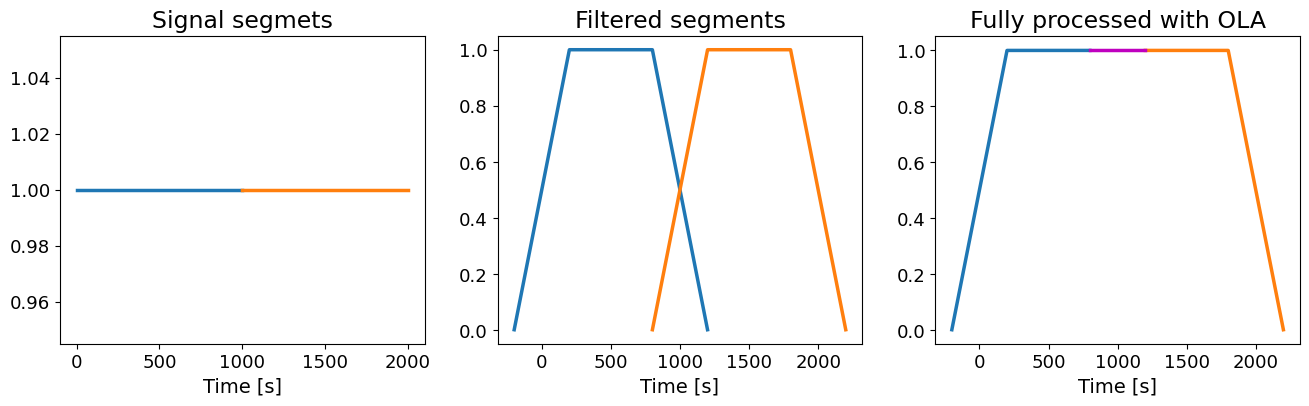

In [57]:
import numpy as np
import matplotlib.pyplot as plt
fontsize = 14
linewidth=2.5

signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16,4))



smoothed = smoothed[window_size//2:-window_size//2]
plt.subplot(1,3,1)
t = np.linspace(0,len(signal),len(signal))
plt.plot(t,signal,linewidth=linewidth)
plt.plot(t+1000,signal,linewidth=linewidth)
#plt.axvline(x = 0, color="red", linestyle="--")
#plt.axvline(x = 1000, color="red", linestyle="--")
plt.title("Signal segmets",fontsize=fontsize+3)
plt.xlabel("Time [s]",fontsize=fontsize)
#plt.ylabel("Amplitude", fontsize=fontsize)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.subplot(1,3,2)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size//2,smoothed,linewidth=linewidth)
plt.plot(smoothed_t + 1000 - window_size//2, smoothed,linewidth=linewidth)
#plt.axvline(x = 0, color="red", linestyle="--")
#plt.axvline(x = len(smoothed) - window_size, color="red", linestyle="--")
plt.title("Filtered segments",fontsize=fontsize+3)
plt.xlabel("Time [s]",fontsize=fontsize)
#plt.ylabel("Amplitude", fontsize=fontsize)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.subplot(1,3,3)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot((smoothed_t-window_size//2)[:-window_size],smoothed[:-window_size],linewidth=linewidth)
plt.plot((smoothed_t + 1000 - window_size//2)[window_size:], smoothed[window_size:],linewidth=linewidth)
plt.plot((smoothed_t-window_size//2)[-window_size:],smoothed[-window_size:]+smoothed[:window_size],linewidth=linewidth,color="m")
plt.title("Fully processed with OLA",fontsize=fontsize+3)
plt.xlabel("Time [s]",fontsize=fontsize)
#plt.ylabel("Amplitude", fontsize=fontsize)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

#plt.tight_layout()

## Implementasjon av OLA i praksis

For å gjennomføre Overlap-Add uten forsinkelse benyttes en buffer-strategi:

- Etter behandling klippes høyre kant og lagres.
- Neste segment behandles med høyre kant fra forrige segment.
- Overlappingen summeres.
- Prosessen gjentas for hvert segment.

Denne teknikken muliggjør sanntidsbehandling med høy nøyaktighet.


## Simulering av live prosessering

Nedenfor er et eksempel på hvordan funksjonen brukes i praksis:

- En loop sender ett og ett segment gjennom `BB_data`.
- Buffere oppdateres mellom hver iterasjon.
- Dette etterligner et live signal fra en mikrofon eller hydrofon.

**Parameterne som kan justeres:**
- `_len`: Lengde på segmenter
- `hilbert_win`: Nedsamplingsfaktor
- `window_size`: Glattingsfilterets varighet

Prøv å endre parametere og observer effekten i plottet.


In [42]:
import functions
import matplotlib.pyplot as plt
import numpy as np

fs = 10000
_len = 100 #lengde på hvert segment i sekunder
hilbert_win=15
window_size=30 #Lengde på konvolusjon filter i sekunder

input_path = "Sound_data/001029.wav"
sx, fs = functions.load_audiofile(input_path, fs, 5, True) #Laster inn lyddata
t = np.linspace(0,len(sx)/fs,len(sx))

fig = plt.figure(figsize=(16,4))
BB2 = [] #Initialiserer buffer for Bredbånd data

sx_buffer = [] #Initialiserer tomt buffer
for k in range(0,int(len(sx)/fs),_len): #Sender lyddata delt opp i segmenter
    BB_current, BB_t, sx_buffer = functions.BB_data(sx[k*fs:((_len+k)*fs)],fs,sx_buffer,hilbert_win,window_size)
    BB2 = np.append(BB2,BB_current) #Legger bredbånddata i buffer

BB2 = BB2 - np.min(BB2) #Justerer nullpunkt for plot
BB_t2 = np.linspace(0,len(BB2)*hilbert_win/fs,len(BB2)) #arbitrær tidsakse
plt.plot(BB_t2, BB2)

for k in range(0,int(len(sx)/fs),_len):
    plt.axvline(x=k,color="red",linestyle="--") #Viser røde linjer i plot for segmentering

plt.xlabel("Time [s]",fontsize=12)
plt.ylabel("Amplitude",fontsize=12)
plt.title("Broadband power-envelope (Segmented) V.2 - 001029",fontsize=17, style='italic')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/data/Processing_scripts/functions.py:114: UserWarning: PySoundFile failed. Trying audioread instead.
  data_offcet, fs = librosa.load(input_file, sr=fs)  # Load the file, returns the audio signal and its sampling rate
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'Sound_data/001029.wav'

## Dokumentasjon: `BB_data`

### Parametere

- `sx`: *(array of float)* – Lydsignal i tidsdomenet
- `fs`: *(int)* – Samplerate (Hz)
- `sx_buff`: *(array of float)* – Buffer fra forrige segment
- `hilbert_win`: *(int)* – Antall samples per nedsampling
- `window_size`: *(float)* – Filtreringsvinduets lengde (sekunder)

### Returverdier

- `BB_sig`: *(array of float)* – Logaritmisk effektomslag
- `t`: *(array of float)* – Tidsakse for `BB_sig`
- `sx_buff_out`: *(array of float)* – Ny buffer for neste segment

### Forventet bruk

Brukeren sender ett segment av gangen til `BB_data`. Output returnerer både signal og ny buffer, som mates inn i neste kall.

Ved initiering: bruk et tomt array som `sx_buff`.

### Notat
Grunnet tidsforkyvningen som følge av null-padding på starten av signalet må starten kuttes fra *første* segment prosessert.
Funksjonen `BB_data` forventer en buffer `sx_buff` fyllt med data fra forrige segment, om `sx_buff` er tom vil funksjonen anta at første segment prosesseres og starten vil kuttes.

Som følge av dette vil bredbånddataen kunne bli påvirket om en feil skulle gjøre at bufferen ikke fylles med data på riktig måte.